## Vector Database
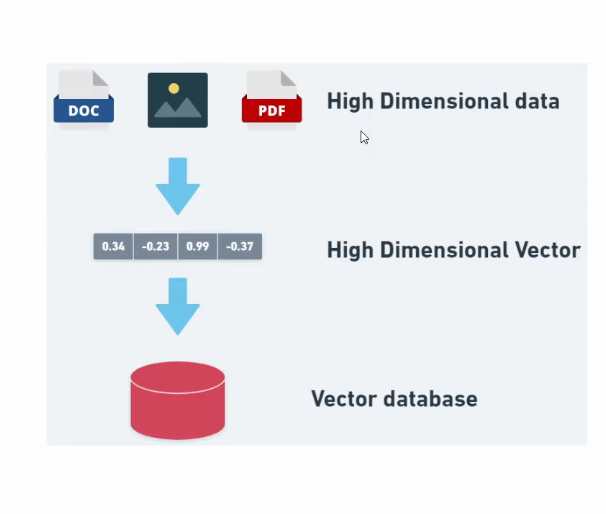

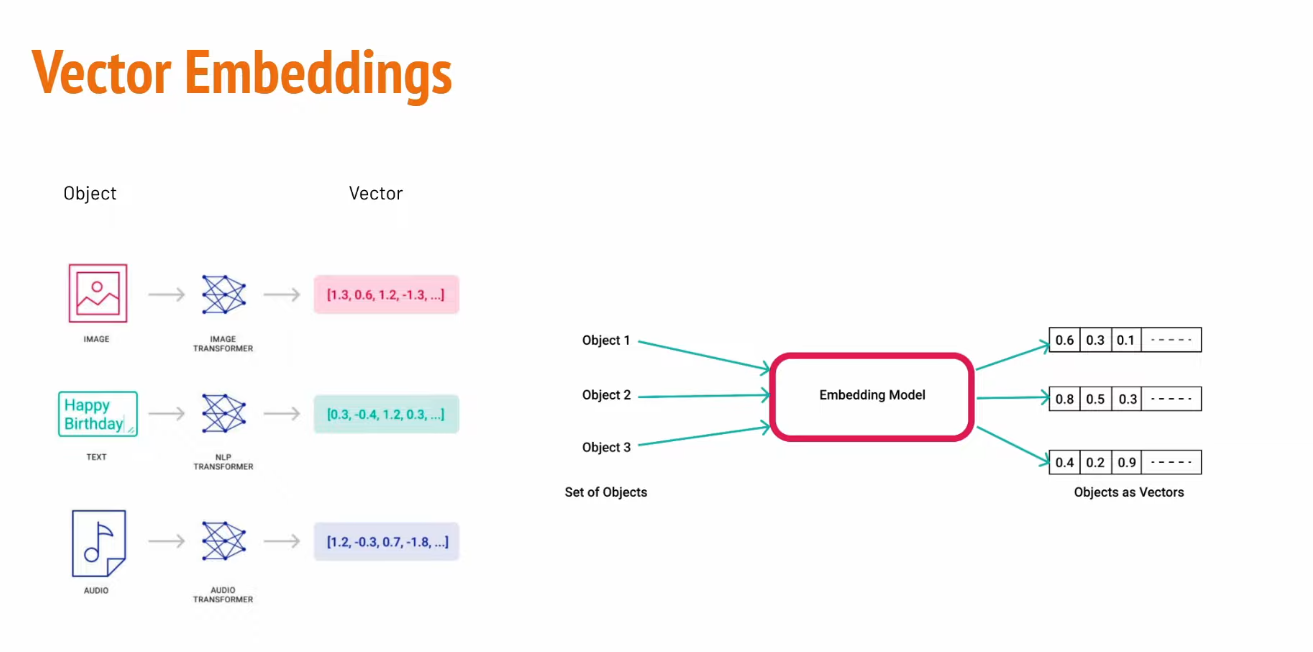

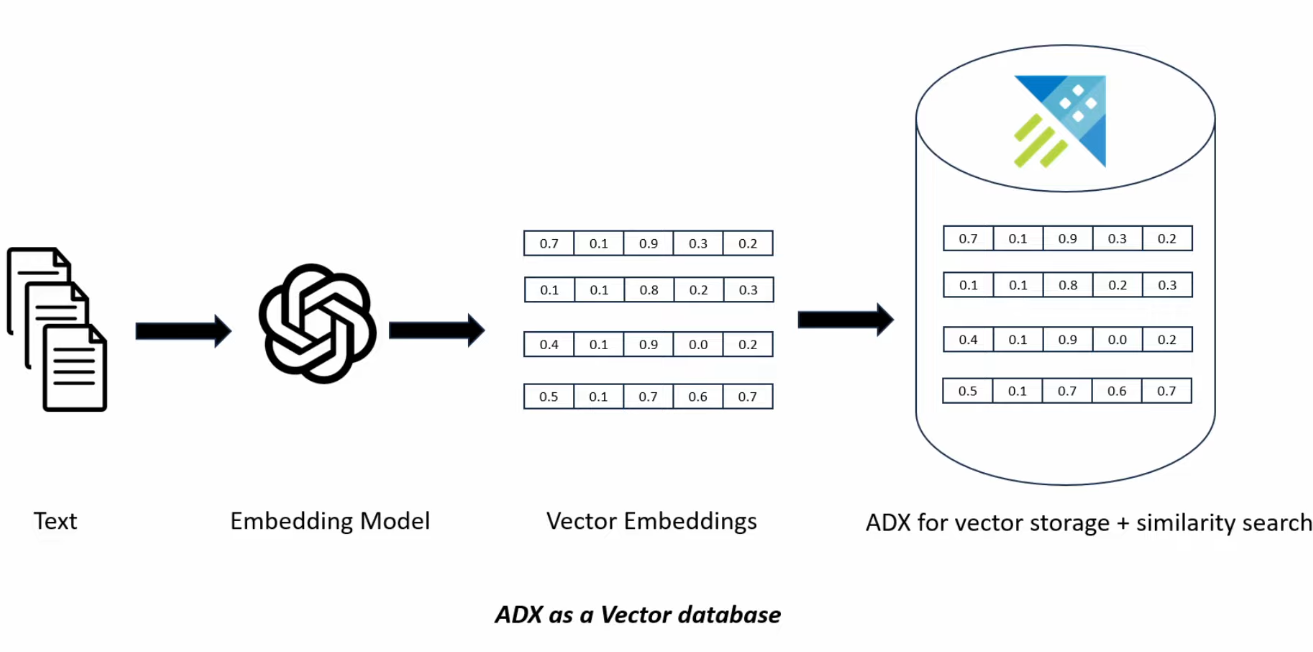

# Unstructure Data as Text

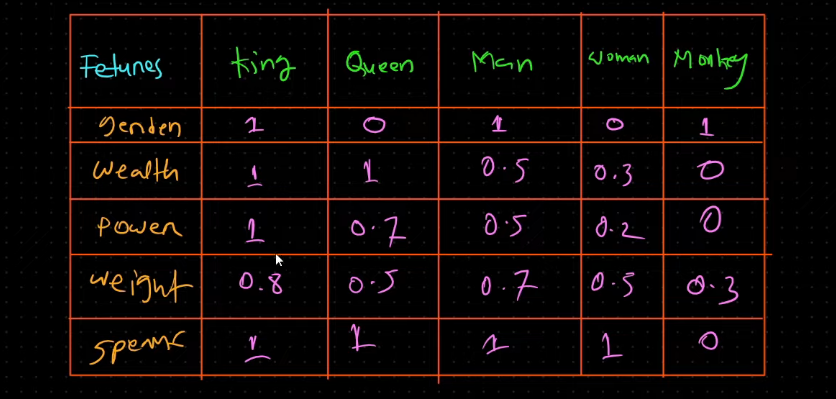


| Word   | Dimension 1 | Dimension 2 | Dimension 3 | Dimension 4 | Dimension 5 |
|--------|------------|------------|------------|------------|------------|
| **King**  | 0.52       | -0.12      | 0.34       | 0.89       | -0.45      |
| **Queen** | 0.48       | -0.14      | 0.37       | 0.91       | -0.42      |
| **Man**   | 0.41       | -0.21      | 0.25       | 0.75       | -0.50      |
| **Woman** | 0.43       | -0.19      | 0.28       | 0.77       | -0.47      |
| **Apple** | -0.10      | 0.89       | -0.75      | 0.34       | 0.12       |
| **Orange**| -0.12      | 0.91       | -0.78      | 0.32       | 0.14       |

### Intuition:
- Words with similar meanings (e.g., "King" and "Queen" or "Apple" and "Orange") have similar embeddings.
- Relationships like **(King - Man) + Woman ≈ Queen** can be observed due to the structure of embeddings.


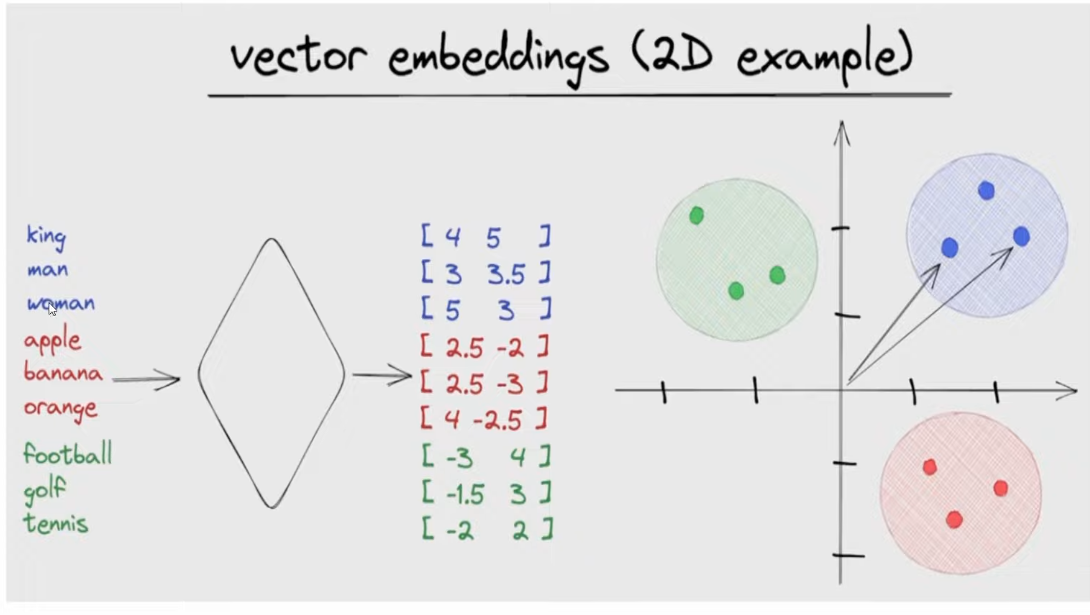

# 🛠 Step 1: Install Dependencies

In [2]:
# ! pip install chromadb langchain langchain-community sentence-transformers tiktoken groq

`chromadb` → Vector database for storing & retrieving embeddings

`langchain` → Framework to manage LLMs, retrieval, and querying

`sentence-transformers` → Hugging Face embeddings

`groq` → LLM API for fast inference

# 📌 Step 2: Set Up Hugging Face Embeddings

In [4]:
from langchain.embeddings import HuggingFaceEmbeddings

hf_embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

🔹 Why this model?

✅ Optimized for speed → Small size, low latency

✅ Good semantic understanding → Works well for retrieval tasks

✅ Industry usage → Used in search & recommendation systems

For higher accuracy, use` bge-large-en` from BAAI:
```python
hf_embeddings = HuggingFaceEmbeddings(model_name="BAAI/bge-large-en")
```

# 📌 Step 3: Initialize ChromaDB for Vector Storage

In [5]:
from langchain.vectorstores import Chroma

# Chroma is a vector store that allows you to store and query embeddings
persist_directory = "./chroma_db"  # Saves embeddings for persistence
vector_db = Chroma(
    persist_directory=persist_directory,  # Saves embeddings for persistence
    embedding_function=hf_embeddings
)


/tmp/ipykernel_82678/1791416021.py:5: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vector_db = Chroma(


🔹 Why ChromaDB?

✅ Lightweight & fast → Runs locally or in the cloud

✅ Persistent storage → Saves vectors for reuse

✅ Scalable → Supports large datasets

# 📌 Step 4: Adding Data to ChromaDB

- (A) Define Sample Documents

In [6]:
documents = [
    "LangChain enables interaction with LLMs for various applications.",
    "ChromaDB is an efficient vector database for document retrieval.",
    "Hugging Face models provide high-quality embeddings for text processing."
]


- (B) Split Long Documents (Chunking)

In [7]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

splitter = RecursiveCharacterTextSplitter(chunk_size=50, chunk_overlap=10) # Split text into chunks of 50 characters with 10 characters overlap
docs = splitter.create_documents(documents)

🔹 Why chunking?

✅ Handles long texts efficiently

✅ Improves retrieval quality

- (C) Store Documents in ChromaDB

In [8]:
vector_db.add_documents(docs)

['1d0b0abc-f5b9-424c-9588-44e163cd27ed',
 'f8d2b4d5-a083-463c-bfd8-b8d571ecc828',
 'f1188cd0-4c24-492f-955f-fce050880d6f',
 '31bbf12e-930e-43b3-83ce-0e39a6e508bd',
 'd99f7f9b-90bd-4540-9ed6-34dac949b638',
 '4f4c15be-1ab1-4d0e-aea1-5bfde30c79e7']

# 📌 Step 5: Search Using ChromaDB

In [9]:
# Just similarity search
query = "What is ChromaDB?"
results = vector_db.similarity_search(query, k=2)

for i, doc in enumerate(results):
    print(f"Result {i+1}: {doc.page_content}")


Result 1: ChromaDB is an efficient vector database for
Result 2: for document retrieval.


In [10]:
# Similarity search with scores
query = "What is ChromaDB?"
results = vector_db.similarity_search_with_score(query, k=2)  # Retrieve top 2 most similar documents with scores

for i, (doc, score) in enumerate(results):
    print(f"Result {i+1}: {doc.page_content}\n Metadata: {doc.metadata}\n Similarity Score: {score}\n")

Result 1: ChromaDB is an efficient vector database for
 Metadata: {}
 Similarity Score: 0.8977339863777161

Result 2: for document retrieval.
 Metadata: {}
 Similarity Score: 1.5700469017028809



🔹 What happens here?

✅ Converts query to embedding

✅ Finds most similar documents

# 📌 Step 6: Integrate ChatGroq API for LLM Responses

In [11]:
import os
from dotenv import load_dotenv
from langchain_groq import ChatGroq

# Load environment variables
load_dotenv()

# Store API keys
groq_api_key = os.environ.get('GROQ_API_KEY')

# Set environment variables for dependent libraries
os.environ["GROQ_API_KEY"] = groq_api_key

groq_llm = ChatGroq(api_key=groq_api_key, model_name="llama3-8b-8192", temperature=0.5)

# 📌 Step 7: Implement Retrieval-Augmented Generation (RAG)

In [12]:
from langchain.chains import RetrievalQA

retriever = vector_db.as_retriever(search_type="similarity", search_kwargs={"k": 2}) # Use ChromaDB as a retriever

qa_chain = RetrievalQA.from_chain_type( # Create a QA chain
    llm=groq_llm,
    retriever=retriever
)

response = qa_chain.run("How does ChromaDB work?")
print(response)

/tmp/ipykernel_82678/4185710461.py:10: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response = qa_chain.run("How does ChromaDB work?")


ChromaDB is an efficient vector database for document retrieval. It works by representing documents as dense vectors in a high-dimensional space, and then using these vectors to perform fast and accurate nearest-neighbor search and retrieval.


# 📌 Step 8: Advanced Use Cases (Industry-Ready)

- (A) Metadata Filtering (For Structured Queries)

In [ ]:
from langchain_core.documents import Document

docs_with_metadata = [
    Document(page_content="ChromaDB is a vector database.", metadata={"category": "database"}),
    Document(page_content="LangChain integrates AI models.", metadata={"category": "AI"})
]

vector_db.add_documents(docs_with_metadata)

# Search with category filter
results = vector_db.similarity_search_with_score("What is ChromaDB?", k=1, filter={"category": "database"})
print(results[0][0].page_content)

ChromaDB is a vector database.


- (B) Hybrid Search (Combining Semantic & Keyword Search)

In [15]:
retriever = vector_db.as_retriever(search_type="mmr", search_kwargs={"k": 3, "fetch_k": 5})
results = retriever.get_relevant_documents("ChromaDB vs LangChain")

for doc in results:
    print(doc.page_content)

qa_chain = RetrievalQA.from_chain_type(
    llm=groq_llm,
    retriever=retriever
)

response = qa_chain.run("What is the difference between ChromaDB and LangChain?")
print(response)

/tmp/ipykernel_94376/2629184256.py:2: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  results = retriever.get_relevant_documents("ChromaDB vs LangChain")


ChromaDB is a vector database.
LangChain enables interaction with LLMs for
LangChain integrates AI models.
Based on the provided context, ChromaDB is a vector database, whereas LangChain enables interaction with LLMs (Large Language Models) for document retrieval.


- (C) Multi-Query Retrieval (Enhancing Recall)

In [17]:
from langchain.retrievers import MultiQueryRetriever

multi_query_retriever = MultiQueryRetriever.from_llm(retriever=retriever, llm=groq_llm)
docs = multi_query_retriever.get_relevant_documents("What is ChromaDB?")

for doc in docs:
    print(doc.page_content)

ChromaDB is an efficient vector database for
for document retrieval.
embeddings for text processing.
ChromaDB is a vector database.
LangChain enables interaction with LLMs for
LLMs for various applications.
LangChain integrates AI models.


🔹 When to use?

✅ Improves recall → Finds more diverse answers

✅ Great for ambiguous querie

- (D) Persist & Reload ChromaDB (Production)

In [18]:
# For large-scale applications, persist embeddings to avoid recomputation.
vector_db.persist()  # Save embeddings to disk

# Reload later
vector_db_reloaded = Chroma(persist_directory="./chroma_db", embedding_function=hf_embeddings)

/tmp/ipykernel_94376/1264596309.py:2: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  vector_db.persist()  # Save embeddings to disk


# Deleteing the DB

In [19]:
!zip -r db.zip ./chroma_db

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  adding: chroma_db/ (stored 0%)
  adding: chroma_db/0be4fbf7-9c93-49d3-a9c7-b2cfe7d28334/ (stored 0%)
  adding: chroma_db/0be4fbf7-9c93-49d3-a9c7-b2cfe7d28334/data_level0.bin (deflated 100%)
  adding: chroma_db/0be4fbf7-9c93-49d3-a9c7-b2cfe7d28334/header.bin (deflated 61%)
  adding: chroma_db/0be4fbf7-9c93-49d3-a9c7-b2cfe7d28334/length.bin (deflated 6%)
  adding: chroma_db/0be4fbf7-9c93-49d3-a9c7-b2cfe7d28334/link_lists.bin (stored 0%)
  adding: chroma_db/chroma.sqlite3 (deflated 88%)


In [20]:
# To cleanup, you can delete the collection
vector_db.delete_collection()
vector_db.persist()

# delete the directory
!rm -rf db/

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [21]:
# Reload later
!unzip db.zip

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Archive:  db.zip
replace chroma_db/0be4fbf7-9c93-49d3-a9c7-b2cfe7d28334/data_level0.bin? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C
